### Step by step derivation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Read in test1.jpg
img = cv2.imread('data/test1.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert to grayscale 
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(img_gray, (3, 3), 0)
blurred_img = np.uint8(blurred_img)

# Perform Canny edge detection
edges = cv2.Canny(blurred_img, 50, 100)

# Find outer closed contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_with_contours = img.copy()
cv2.drawContours(img_with_contours, contours, -1, (0,255,0), 3)

array([[[201, 191, 179],
        [201, 191, 179],
        [201, 191, 179],
        ...,
        [183, 175, 154],
        [182, 174, 153],
        [181, 173, 152]],

       [[199, 189, 177],
        [199, 189, 177],
        [198, 188, 176],
        ...,
        [181, 173, 152],
        [180, 172, 151],
        [178, 170, 149]],

       [[199, 189, 177],
        [199, 189, 177],
        [198, 188, 176],
        ...,
        [179, 171, 150],
        [178, 170, 149],
        [177, 169, 148]],

       ...,

       [[ 24,  24,  24],
        [ 23,  23,  23],
        [ 23,  23,  23],
        ...,
        [187, 179, 160],
        [188, 180, 161],
        [188, 180, 161]],

       [[ 24,  24,  24],
        [ 23,  23,  23],
        [ 23,  23,  23],
        ...,
        [187, 179, 160],
        [188, 180, 161],
        [189, 181, 162]],

       [[ 28,  28,  28],
        [ 26,  26,  26],
        [ 25,  25,  25],
        ...,
        [187, 179, 160],
        [188, 180, 161],
        [189, 181, 162]]

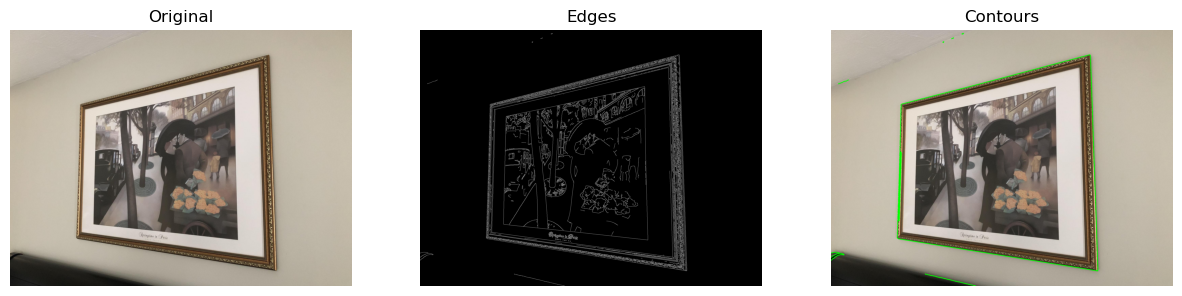

Number of contours detected: 47


In [3]:
# Plot the images to visualise
plt.figure(figsize=(15,15))

plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(132)
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title('Edges')

plt.subplot(133)
plt.imshow(img_with_contours)
plt.axis('off')
plt.title('Contours')

plt.show()

num_contours = len(contours)
print("Number of contours detected:", num_contours)

In [4]:
# Find the contour with the largest area
largest_area = 0
largest_contour = None
for contour in contours:
    area = cv2.contourArea(contour)
    if area > largest_area:
        largest_area = area
        largest_contour = contour

# Draw the largest contour on a blank canvas
canvas = np.zeros_like(img_gray)
cv2.drawContours(canvas, [largest_contour], -1, (255, 255, 255), cv2.FILLED)

# Mask the original image with the contour
# This isolates the object (valid) from the background (black)
masked_image = cv2.bitwise_and(img, img, mask=canvas)

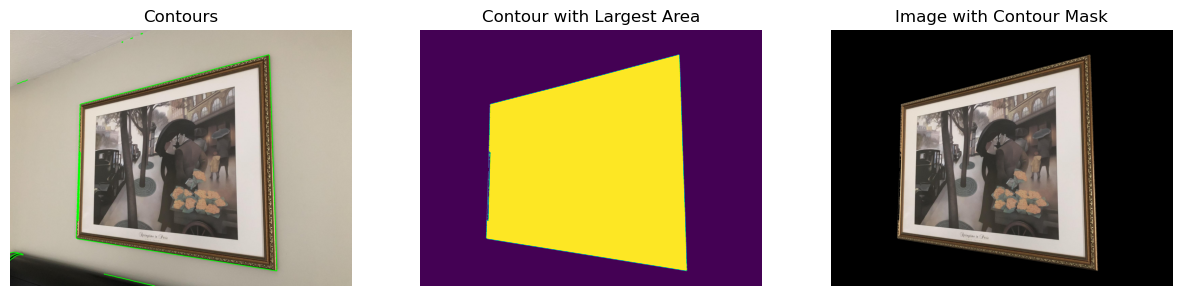

In [5]:
# Plot the images to visualise
plt.figure(figsize=(15,15))

# Display the masked image

plt.subplot(131)
plt.imshow(img_with_contours)
plt.axis('off')
plt.title('Contours')

plt.subplot(132)
plt.imshow(cv2.drawContours(canvas, [largest_contour], -1, (255, 255, 255), cv2.FILLED))
plt.axis('off')
plt.title('Contour with Largest Area')

plt.subplot(133)
plt.imshow(masked_image)
plt.axis('off')
plt.title('Image with Contour Mask')

plt.show()

In [6]:
# Approximate the largest contour to find the 4 corner points
epsilon = 0.05 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

# Sort the 4 corner points based on their coordinates
sorted_corners = sorted(approx.reshape(-1, 2), key=lambda x: x[1])

top_corners = sorted(sorted_corners[:2], key=lambda x: x[0])
bottom_corners = sorted(sorted_corners[2:], key=lambda x: x[0])

# Find the top-left, top-right, bottom-left, and bottom-right corners
top_left_corner = top_corners[0]
top_right_corner = top_corners[1]
bottom_left_corner = bottom_corners[0]
bottom_right_corner = bottom_corners[1]

Top Left Corner: [414 442]
Top Right Corner: [1528  153]
Bottom Left Corner: [ 390 1230]
Bottom Right Corner: [1571 1423]


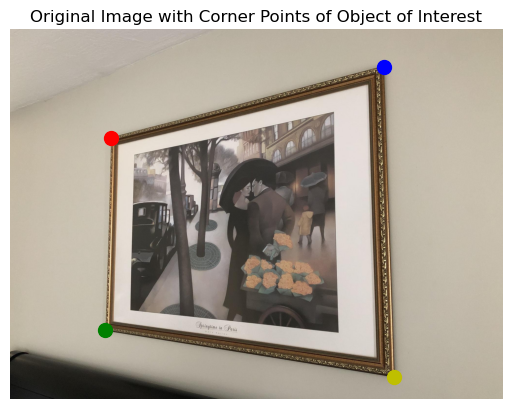

In [7]:
# Print the coordinates of the corners
print("Top Left Corner:", top_left_corner)
print("Top Right Corner:", top_right_corner)
print("Bottom Left Corner:", bottom_left_corner)
print("Bottom Right Corner:", bottom_right_corner)

# Plot the original image
plt.imshow(img)

# Plot the corners as circles
plt.plot(top_left_corner[0], top_left_corner[1], 'ro', markersize=10)  # Top Left
plt.plot(top_right_corner[0], top_right_corner[1], 'bo', markersize=10)  # Top Right
plt.plot(bottom_left_corner[0], bottom_left_corner[1], 'go', markersize=10)  # Bottom Left
plt.plot(bottom_right_corner[0], bottom_right_corner[1], 'yo', markersize=10)  # Bottom Right

plt.axis('off')
plt.title('Original Image with Corner Points of Object of Interest')
plt.show()

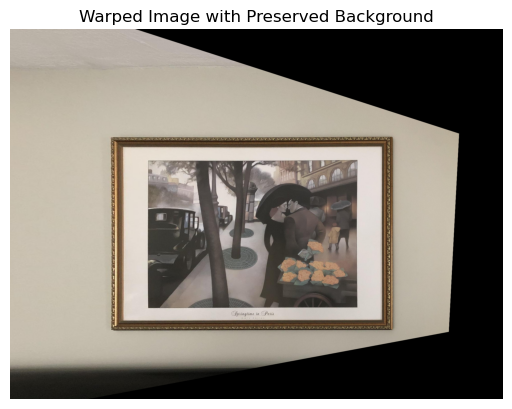

In [8]:
# Define the coordinates of the rectangle corners in the original image
original_corners = np.float32([top_left_corner, top_right_corner, bottom_right_corner, bottom_left_corner])
img_height, img_width = img.shape[:2]

# Calculate the width and height of the rectangle in the original image
width = round(np.linalg.norm(top_left_corner - top_right_corner))
height = round(np.linalg.norm(top_left_corner - bottom_left_corner))

# Fix the top-left corner
x = original_corners[0,0]
y = original_corners[0,1]

# Specify the destination corners to warp to
destination_corners = np.float32([[x, y], [x+width-1, y], [x+width-1, y+height- 1], [x, y+height-1]])

# Compute perspective matrix
perspective_matrix = cv2.getPerspectiveTransform(original_corners, destination_corners)

# Warp the image
warped_img = cv2.warpPerspective(img, perspective_matrix, (img_width, img_height))

# Plot the warped image
plt.imshow(warped_img)
plt.title('Warped Image with Preserved Background')
plt.axis('off')
plt.show()

In [9]:
# Output in .png format
warped_img_rgb = cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)

# Save the warped image as PNG
# cv2.imwrite('warped_image1.png', warped_img_rgb)

### Prepare for submission

In [10]:
def imrect(im1):
# Perform Image rectification on an 3D array im.
# Parameters: im1: numpy.ndarray, an array with H*W*C representing image.(H,W is the image size and C is the channel)
# Returns: out: numpy.ndarray, rectified image。
#   out =im1

    # Make a copy of the input image
    img = im1.copy()
    
    # Convert to grayscale 
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred_img = cv2.GaussianBlur(img_gray, (3, 3), 0)
    blurred_img = np.uint8(blurred_img)
    
    # Perform Canny edge detection
    edges = cv2.Canny(blurred_img, 50, 100)
    
    # Find outer closed contours
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_contours = img.copy()
    cv2.drawContours(img_with_contours, contours, -1, (0,255,0), 3)

    # Find the contour with the largest area
    largest_area = 0
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            largest_area = area
            largest_contour = contour
    
    # Draw the largest contour on a blank canvas
    canvas = np.zeros_like(img_gray)
    cv2.drawContours(canvas, [largest_contour], -1, (255, 255, 255), cv2.FILLED)
    
    # Mask the original image with the contour
    # This isolates the object (valid) from the background (black)
    masked_image = cv2.bitwise_and(img, img, mask=canvas)

    # Approximate the largest contour to find the 4 corner points
    epsilon = 0.05 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    # Sort the 4 corner points based on their coordinates
    sorted_corners = sorted(approx.reshape(-1, 2), key=lambda x: x[1])
    
    top_corners = sorted(sorted_corners[:2], key=lambda x: x[0])
    bottom_corners = sorted(sorted_corners[2:], key=lambda x: x[0])
    
    # Find the top-left, top-right, bottom-left, and bottom-right corners
    top_left_corner = top_corners[0]
    top_right_corner = top_corners[1]
    bottom_left_corner = bottom_corners[0]
    bottom_right_corner = bottom_corners[1]

    # Define the coordinates of the rectangle corners in the original image
    original_corners = np.float32([top_left_corner, top_right_corner, bottom_right_corner, bottom_left_corner])
    img_height, img_width = img.shape[:2]
    
    # Calculate the width and height of the rectangle in the original image
    width = round(np.linalg.norm(top_left_corner - top_right_corner))
    height = round(np.linalg.norm(top_left_corner - bottom_left_corner))
    
    # Fix the top-left corner
    x = original_corners[0,0]
    y = original_corners[0,1]
    
    # Specify the destination corners to warp to
    destination_corners = np.float32([[x, y], [x+width-1, y], [x+width-1, y+height- 1], [x, y+height-1]])
    
    # Compute perspective matrix
    perspective_matrix = cv2.getPerspectiveTransform(original_corners, destination_corners)
    
    # Warp the image
    out = cv2.warpPerspective(img, perspective_matrix, (img_width, img_height))
        
    return (out)

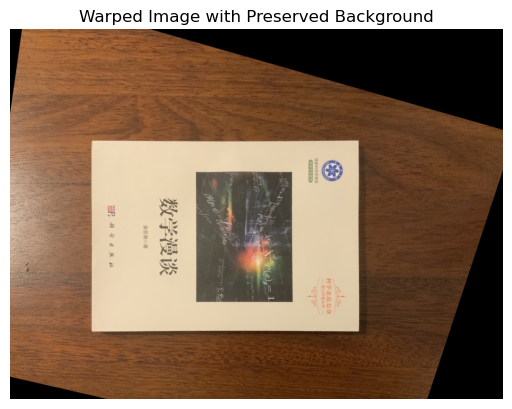

In [11]:
# Test the function
img = cv2.imread('data/test2.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out = imrect(img)

# Plot the warped image
plt.imshow(out)
plt.title('Warped Image with Preserved Background')
plt.axis('off')
plt.show()